In [9]:
cd /tf/astromer/

/tf/astromer


In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

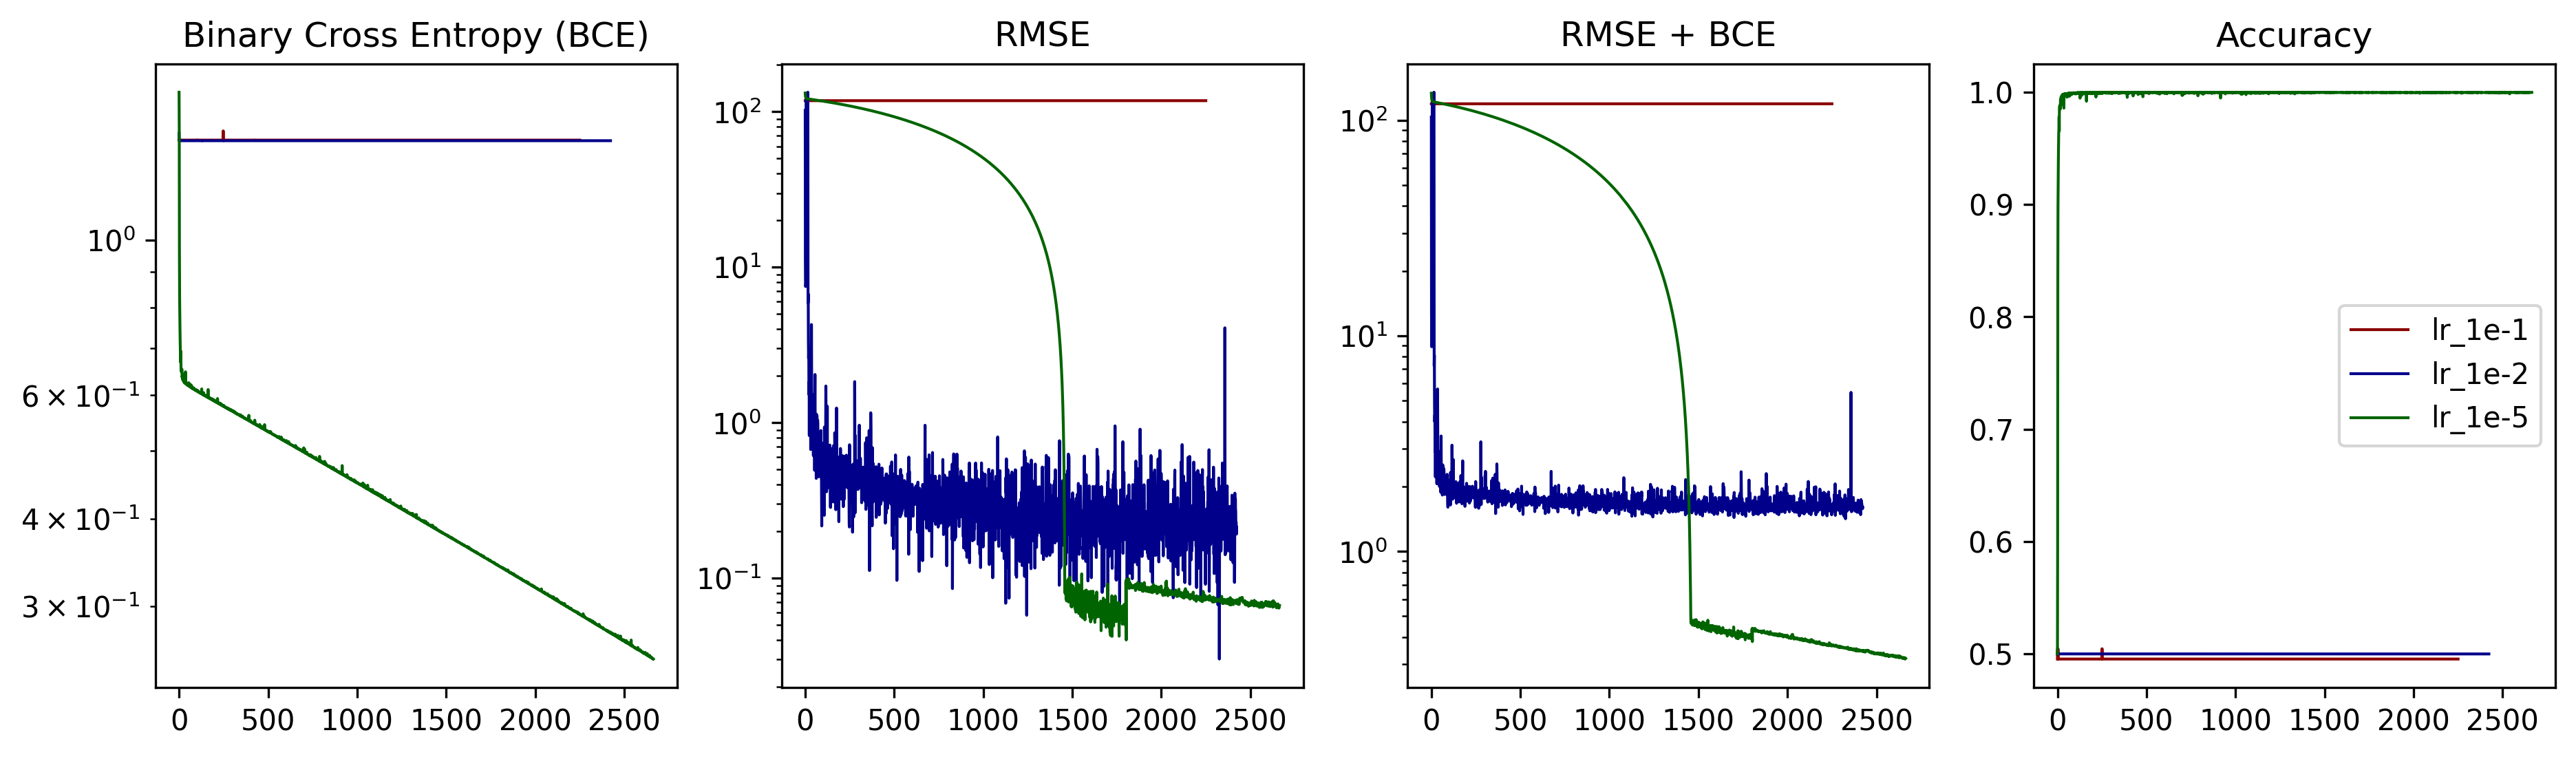

In [50]:
root = './runs'
fig, axes = plt.subplots(1, 4, figsize=(15,4), dpi=300)
colors = ['darkred','darkblue', 'darkgreen']
experiments = ['lr_1e-1', 'lr_1e-2','lr_1e-5']
for color, folder in zip(colors, experiments):

    val_metrics = get_metrics(os.path.join(root, folder, 'logs', 'valid'))

    axes[0].plot(val_metrics['bce'], label=folder, linewidth=1, color=color)
    axes[1].plot(val_metrics['mse'], label=folder, linewidth=1, color=color)
    axes[2].plot(val_metrics['loss'], label=folder, linewidth=1, color=color)
    axes[3].plot(val_metrics['accuracy'], label=folder, linewidth=1, color=color)
    
    axes[0].set_yscale('log')
    axes[1].set_yscale('log')
    axes[2].set_yscale('log')

      
    axes[0].set_title('Binary Cross Entropy (BCE)')
    axes[1].set_title('RMSE')
    axes[2].set_title('RMSE + BCE')  
    axes[3].set_title('Accuracy')
    
plt.legend()
